In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from filters.filters import IEKF, Madgwick
from tools.objects import Gaussian
from tools import compare, data_processing, transform, utils
from tools.tools_ahrs import plot
import mrob

In [8]:
DATA = "record" # 'tum' or 'record'

# Load Data

In [10]:
if DATA == 'tum':
    x3_path = os.path.join("../data", "TUM-VI", "imu0")
    mocap_path = os.path.join("../data", "TUM-VI", "mocap0")
    take_name = "outdoors1.csv"

    downscale = 1

    t_base, data_gyr, data_acc = data_processing.import_tum_imu(os.path.join(x3_path, take_name), smoothing=False)
    t_base, data_gyr, data_acc = data_processing.downsample(downscale, t_base, data_gyr, data_acc)

    freq_my = 120/downscale # Hz

    data_mocap_t, data_mocap_q, data_mocap_T = data_processing.import_tum_mocap(os.path.join(mocap_path, take_name), smoothing=False)
    data_mocap_t, data_mocap_q, data_mocap_T = data_processing.downsample(downscale, data_mocap_t, data_mocap_q, data_mocap_T)

    t_base, data_gyr, data_acc, data_acc, data_mocap_q = data_processing.sync_mocap_and_data(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

else:
    x3_path_my = os.path.join("../data", "X3_simple", "Random_walk_2025-03-06_19-02-36.207_TGW")
    # x3_path = "madgwick_filter/recordings/X3_simple/Standing_still_2025-03-06_18-50-19.416_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Basic_motions_2025-03-06_18-45-09.848_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Walking_2025-03-06_18-37-32.144_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Walking_talking_2025-03-06_18-41-53.764_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Random_walk_2025-03-06_19-02-36.207_TGW"

    mocap_path_my = os.path.join("../data", "Mocap_simple", "Random_walk_Take 2025-03-06 06.38.58 PM_004.csv")
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Standing_still_Take 2025-03-06 06.38.58 PM_003.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Basic_motions_Take 2025-03-06 06.38.58 PM_002.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_Take 2025-03-06 06.38.58 PM.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_talking_Take 2025-03-06 06.38.58 PM_001.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Random_walk_Take 2025-03-06 06.38.58 PM_004.csv"

    t_base, data_gyr, data_acc, data_magn = data_processing.import_combined_data(os.path.join(x3_path_my, "combined_imu_data_7.csv"))
    t_base = t_base/1000
    data_mocap_t, data_mocap_q = data_processing.import_gamerotvec_data(os.path.join(x3_path_my, "game_rotation_vector_12.csv"))
    data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc= data_processing.trim_to_min_length(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

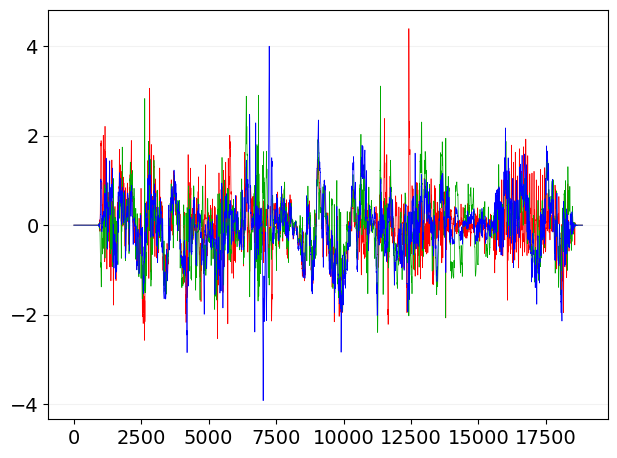

In [11]:
plot(data_gyr)

# Apply filter

## IEKF

In [12]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e-4 * np.eye(3, 3)                                 # rad/s         ~(0.00122 ** 2) from sensors.csv
Q = 1e-3 * np.eye(3, 3) * (9.81 ** 2)                   # rads * g^2    ~(0.00239 ** 2) from sensors.csv
# worse results with covs from sensors or from np.cov
#M = np.diag(np.diag(action_cov))
#Q = np.diag(np.diag(measurement_cov))
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0, 0.000])
iekf = IEKF(initial_state, M, Q, g, u_bias)
u = data_gyr
N = len(data_gyr)
dts = np.empty(N)
freq_sm = 200
dts[0] = 1/freq_sm
dts[1:] = np.array([t_base[i+1] - t_base[i] for i in range(N-1)])
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))
gt = transform.quats_to_rpy(data_mocap_q)

for i in range(N):
    iekf.predict(u[i], dts[i])
    Ks[i], IVs[i] = iekf.update(data_acc[i])
    #iekf.update_fake()
    preds[i, :] = iekf.mu_bar
    s_preds[i] = iekf.Sigma_bar
    ups[i] = iekf.mu
    s_ups[i] = iekf.Sigma

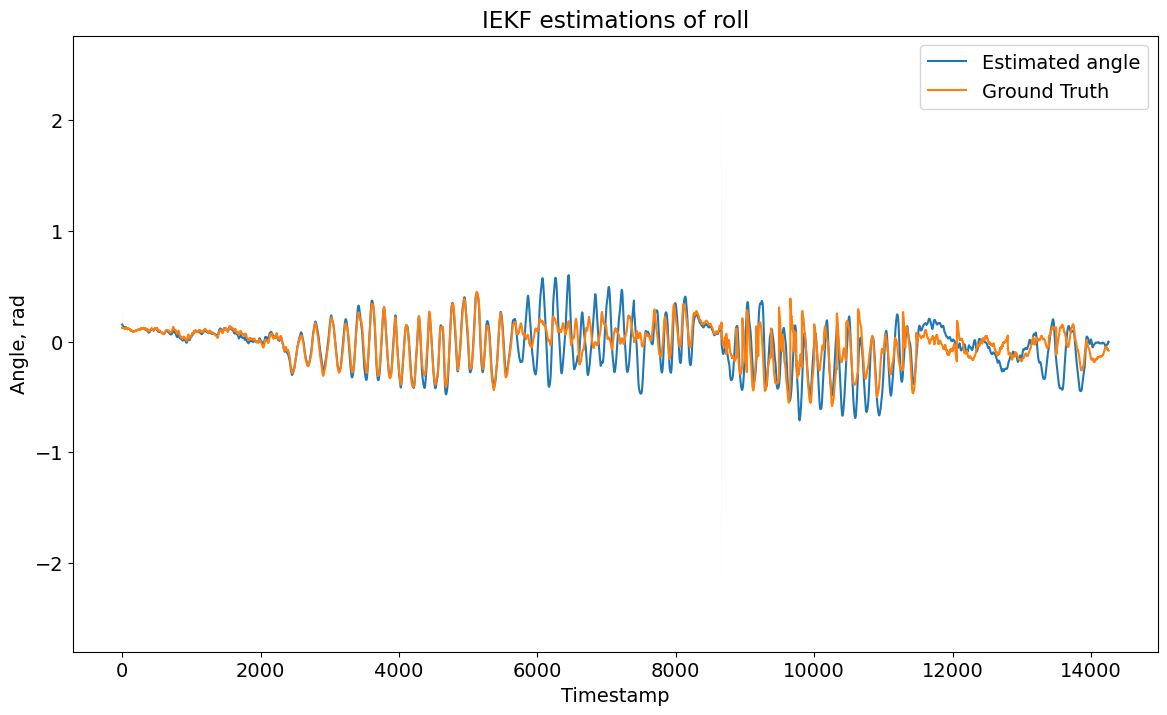

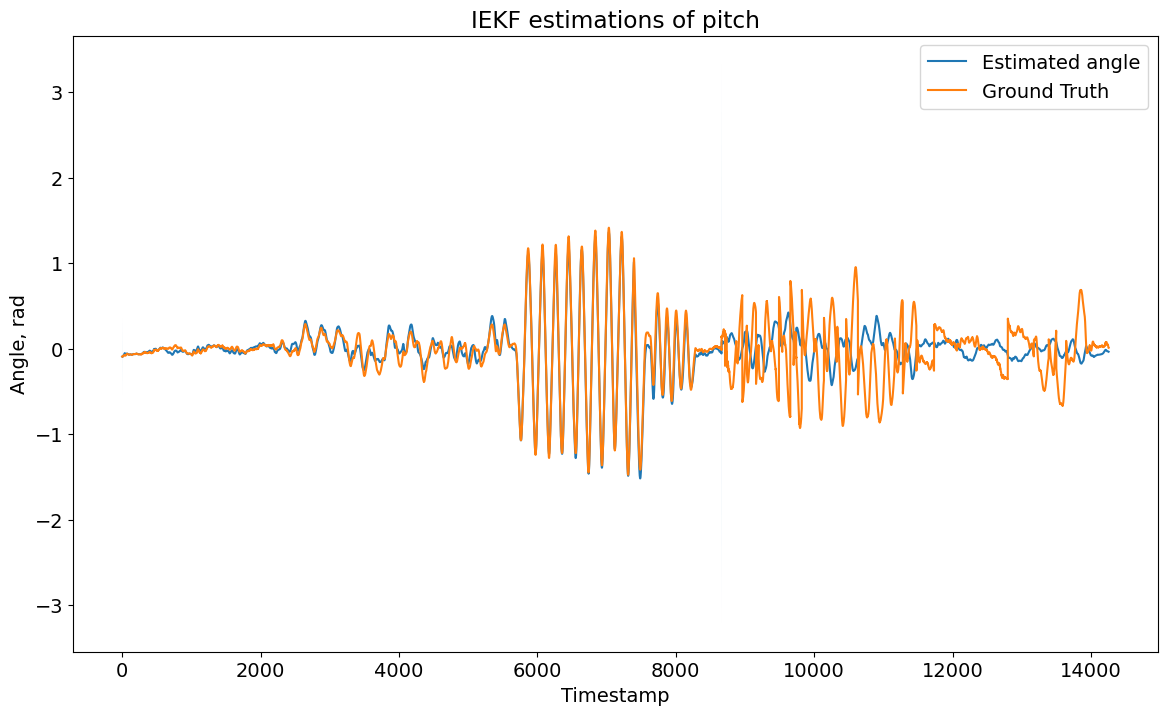

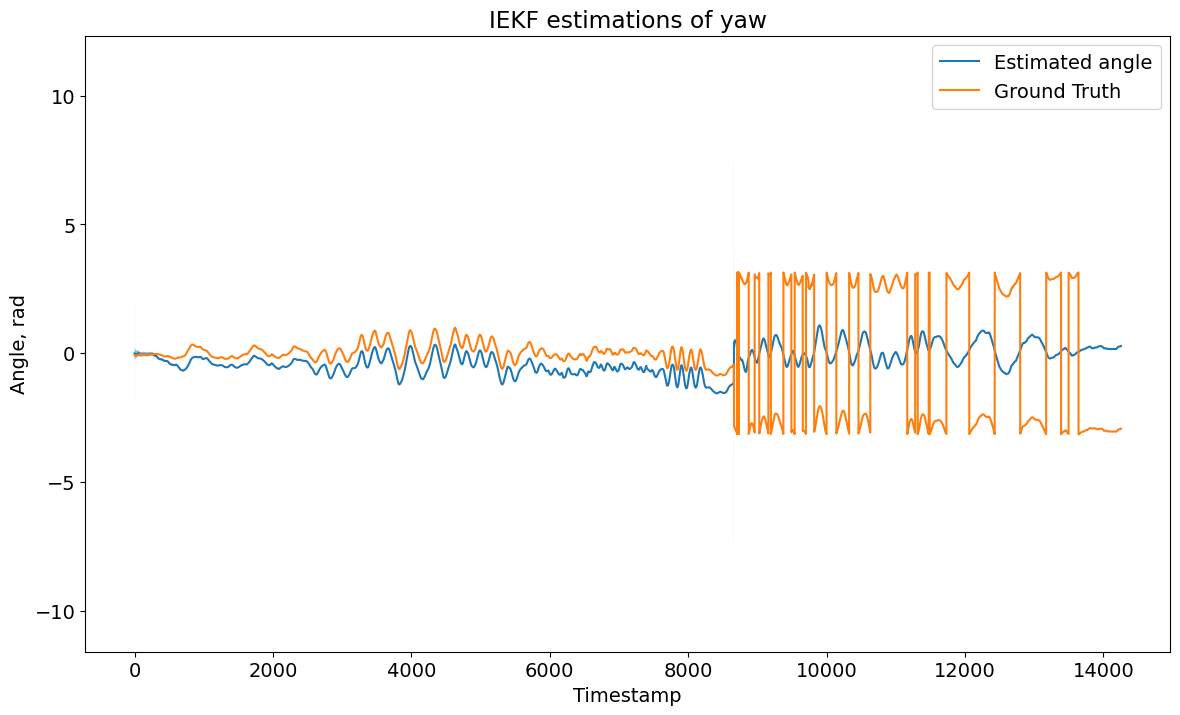

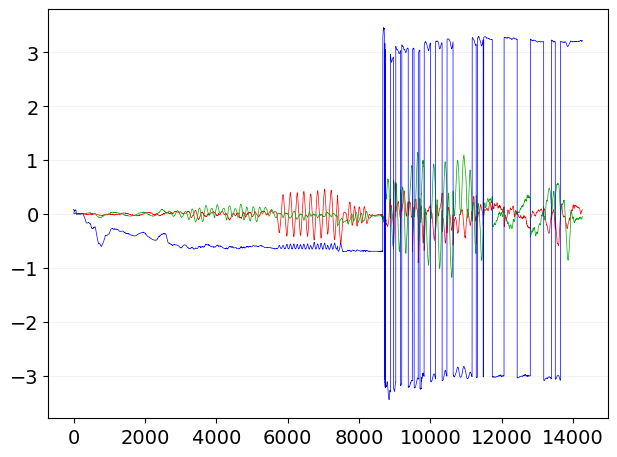

In [13]:
compare.plot_covs(ups, s_ups, 0, gt)
compare.plot_covs(ups, s_ups, 1, gt)
compare.plot_covs(ups, s_ups, 2, gt)
plot(ups - gt)

Mean distance between smartphone and mocap RPY attitude estimations:
[0.10339858 0.1570343  1.54806329]
STD of distance between smartphone and mocap RPY attitude estimations:
[0.12539367 0.22452282 1.26843588]
Distance between smartphone and mocap RPY attitude estimations:


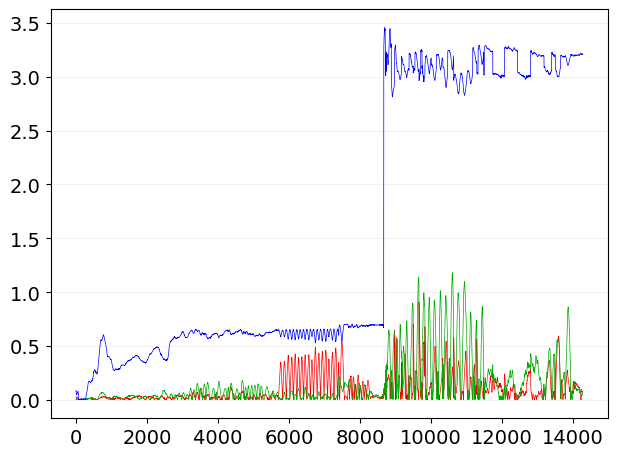

Last distance between smartphone and mocap RPY attitude estimations:
[0.08103224 0.04545753 3.20982695]
RMSE of APE between smartphone and mocap RPY attitude estimations:
[0.16252303 0.27398309 2.00132873]


Mean distance between smartphone and mocap RPY vector g estimations:
[0.01936411 0.02655647 0.00508398]
STD of distance between smartphone and mocap RPY vector g estimations:
[0.01863746 0.02636451 0.00663738]
Distance between smartphone and mocap RPY vector g estimations:


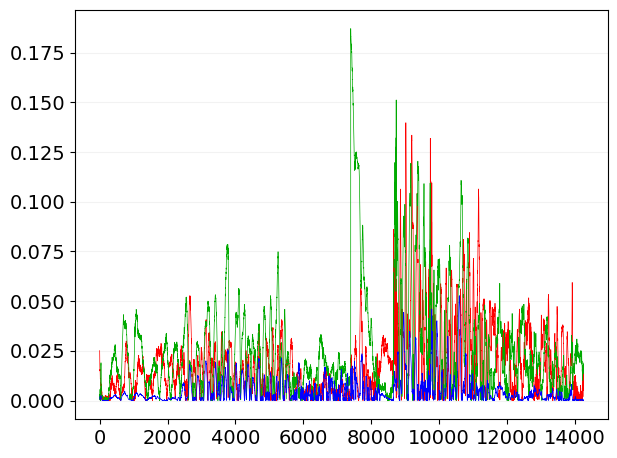

Last distance between smartphone and mocap RPY vector g estimations:
[5.20594456e-03 1.89154157e-02 6.20479018e-05]
RMSE of APE between smartphone and mocap RPY vector g estimations:
[0.02687562 0.03742038 0.00836054]


Mean Relative Pose Error
[3.88497345 9.67873513 5.3948822 ]
STD of distance between smartphone and mocap RPY attitude estimations:
[ 39.24990684 155.07487694  95.73869405]
Relative Pose Error RPY


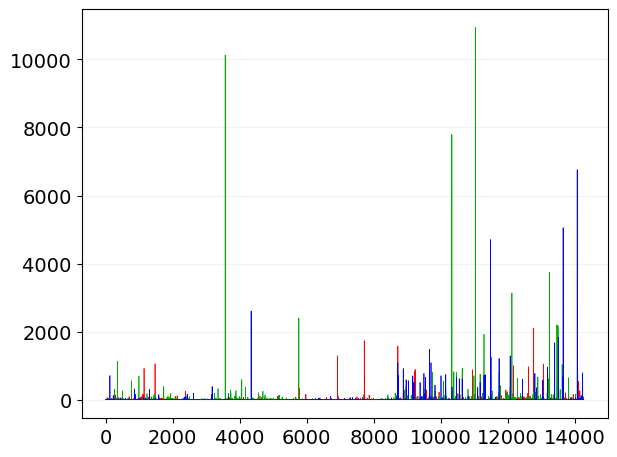

Last RPE between smartphone and mocap RPY attitude estimations:
[2.47947751 0.66360949 2.80942573]
RMSE of RPE between smartphone and mocap RPY attitude estimations:
[ 39.44033638 155.37119543  95.88722176]


Mean Relative Pose Error of vector g
[5.32262733 4.15613969 5.59463321]
STD of distance between smartphone and mocap RPY vector g estimations:
[173.13465616  70.41128165 154.28485025]
Relative Pose Error RPY of vector g


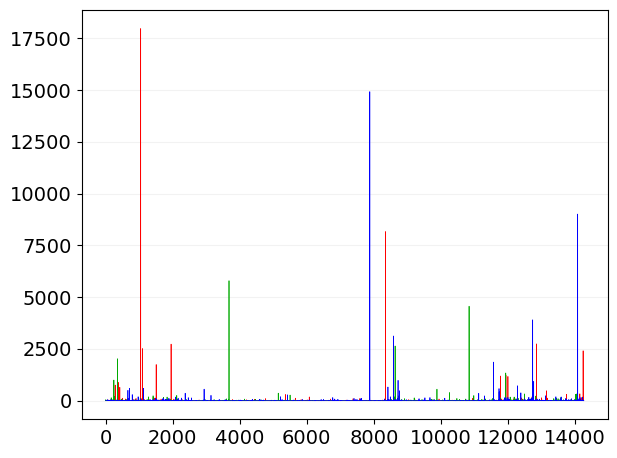

Last RPE between smartphone and mocap RPY vector g estimations:
[0.17111855 4.57064168 0.29834738]
RMSE of RPE between smartphone and mocap RPY vector g estimations:
[173.21038281  70.53137097 154.38084428]




(array([[2.89253361e-02, 2.28133802e-03, 7.97213744e-02],
        [2.55430654e-02, 4.96425919e-03, 8.44125205e-02],
        [2.38750733e-02, 6.22037047e-03, 8.38016931e-02],
        ...,
        [7.72548985e-02, 4.63268932e-02, 3.20817818e+00],
        [7.86992147e-02, 4.60658433e-02, 3.21283468e+00],
        [8.10322382e-02, 4.54575339e-02, 3.20982695e+00]]),
 array([[2.51492569e-02, 2.94471486e-03, 1.90089518e-03],
        [2.15132495e-02, 7.12900625e-04, 1.87645362e-03],
        [1.98506142e-02, 5.67216783e-04, 1.90336276e-03],
        ...,
        [7.14368161e-03, 1.44566497e-02, 1.94214117e-04],
        [6.47493167e-03, 1.56194997e-02, 1.57857313e-04],
        [5.20594456e-03, 1.89154157e-02, 6.20479018e-05]]),
 array([[ 4.59479706,  0.72531213,  0.67653042],
        [ 0.53691051,  0.7756906 ,  0.3732802 ],
        [ 2.46991423,  5.03660499,  0.2372249 ],
        ...,
        [ 0.87932477, 21.71160548,  1.69996866],
        [ 4.65816341,  2.82254883,  2.1580661 ],
        [ 2.4794

In [9]:
compare.errors_estimation_rpy(gt, ups)

## Madgwick

In [12]:
madgwick_filter = Madgwick()
madgwick_result = madgwick_filter.apply(data_gyr=data_gyr,
                      data_acc=data_acc,
                      freq=freq_my if freq_my is not None else 1)

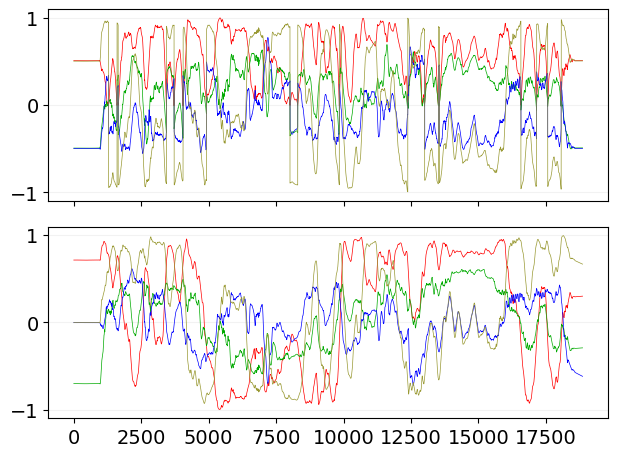

In [13]:
plot(data_mocap_q, madgwick_result.Q)

Mean distance between sensors and mocap attitude estimations:
1.03675350636704
STD of distance between sensors and mocap attitude estimations:
0.6384385487482802
Distance between sensors and mocap attitude estimations:


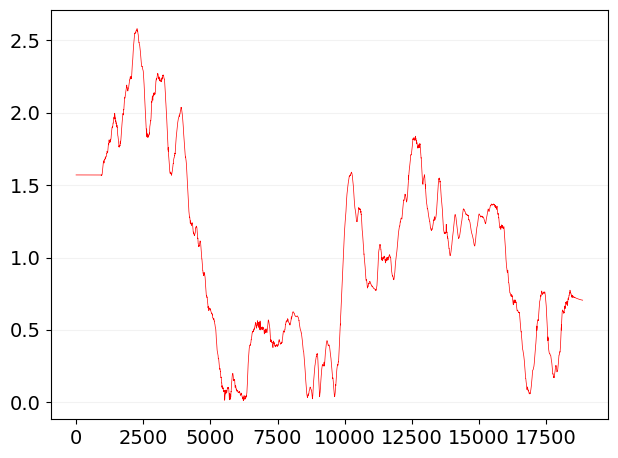

Last distance between sensors and mocap attitude estimations:
0.7057236265456811
RMSE of APE between sensors and mocap attitude estimations:
1.2175549270027777


G vectors in smartphone and (mocap-observed-smartphone) reference frames


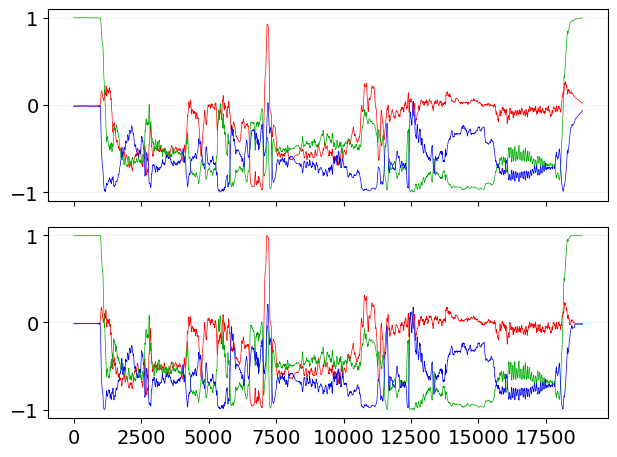

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


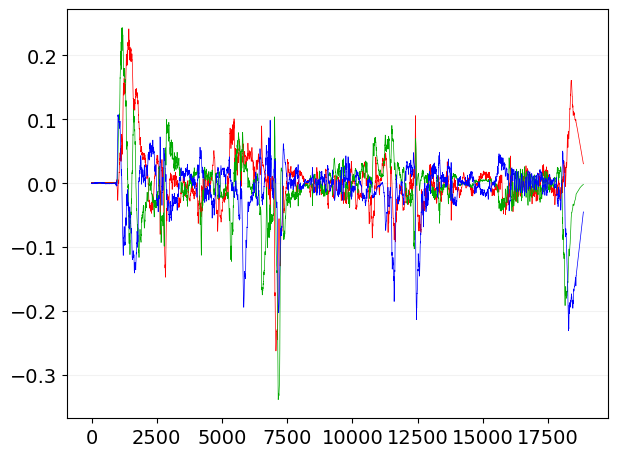

Mean distance between sensors and mocap vector g estimations:
0.054858132148624866
STD of distance between sensors and mocap vector g estimations:
0.06255870872808615
Distance between sensors and mocap vector g estimations:


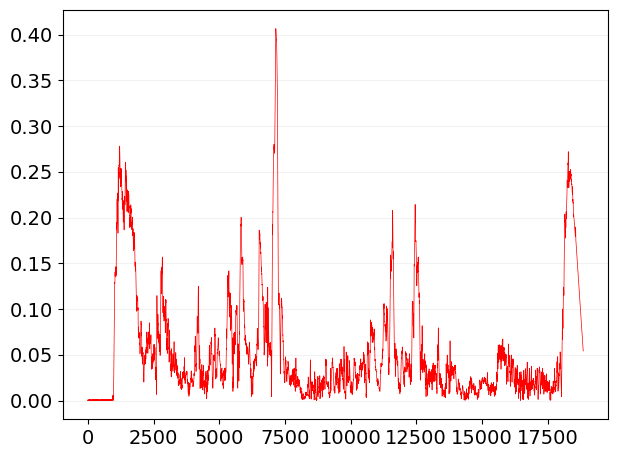

Last distance between sensors and mocap vector g estimations:
0.05430658151990486
RMSE of APE between sensors and mocap vector g estimations:
0.08320336040105138


Mean Relative Pose Error
0.0025436289728069934
STD of distance between sensors and mocap attitude estimations:
0.002012569508556375
Relative Pose Error


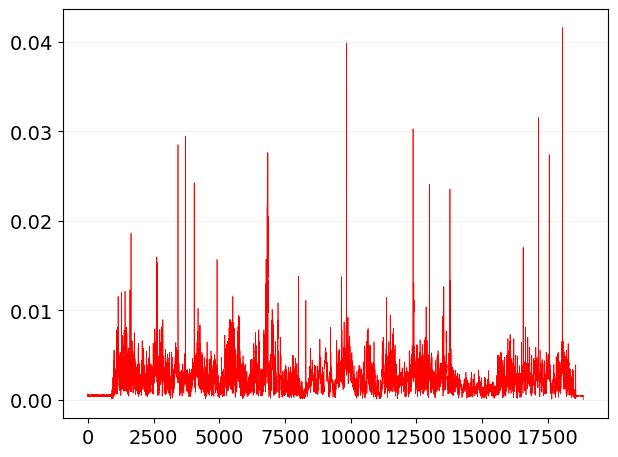

Last RPE between sensors and mocap attitude estimations:
1.4651035744039358e-05
RMSE of RPE between sensors and mocap attitude estimations:
0.0032434965071643147


Mean Relative Pose Error of vector g
0.006081843892749155
STD of distance between sensors and mocap vector g estimations:
0.005876936340825743
Relative Pose Error of vector g


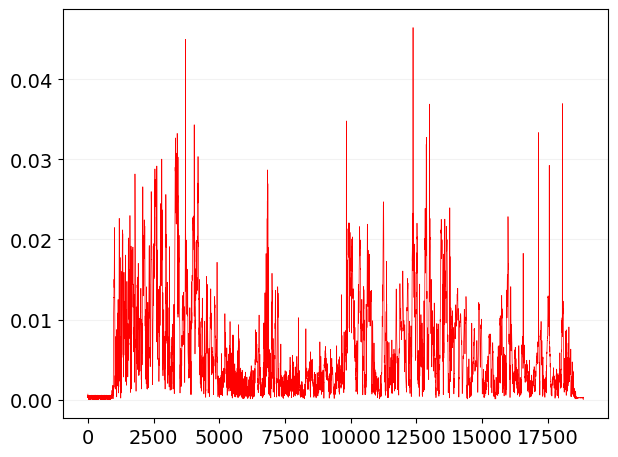

Last RPE between sensors and mocap vector g estimations:
8.864661334747953e-06
RMSE of RPE between sensors and mocap vector g estimations:
0.008457267548821002




(array([1.57079507, 1.57079412, 1.5707932 , ..., 0.70575042, 0.70572254,
        0.70572363]),
 array([0.00079995, 0.00018633, 0.0005308 , ..., 0.05471943, 0.05429196,
        0.05430658]),
 array([7.31291056e-04, 3.77691349e-04, 3.65344089e-04, ...,
        4.44597419e-04, 4.28548414e-04, 1.46510357e-05]),
 array([6.93399303e-04, 3.65894621e-04, 2.49685614e-04, ...,
        2.25062134e-04, 2.13111518e-04, 8.86466133e-06]))

In [14]:
compare.errors_estimation(madgwick_result.Q, data_mocap_q, source1="sensors")